# Example 1: Single-Mode Conversion (Gaussian → Flat-Top Square)

This example demonstrates inverse design of two phase masks to transform a Gaussian beam into a flat-top intensity profile using differentiable propagation.

## Physical Setup

We place two trainable phase masks separated by free-space propagation:
- **Input**: Gaussian beam (w₀ = 75 μm)
- **Target**: Square flat-top (75 μm width)
- **System**: Free space (z₀) → Phase mask 1 → Free space (z₁₂) → Phase mask 2 → Free space (z₀)

The optimizer adjusts both phase masks to minimize intensity difference between output and target.

## Setup and Dependencies

In [1]:
import equinox as eqx
import optax
import jax
import jax.numpy as jnp
from jaxoptics import *
import matplotlib.pyplot as plt
import tqdm

## Define Input and Target Beams

We create a Gaussian input beam and a square flat-top target using a super-Gaussian profile:

In [2]:
def square(c0: float, n: float):
    def mode(x, y):
        return jnp.exp(-((x/c0)**n + (y/c0)**n))
    return mode

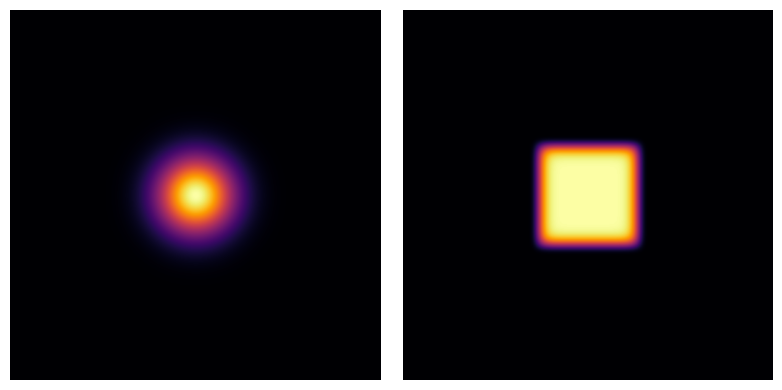

(<Figure size 800x400 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

In [3]:
# Simulation parameters
ns = (512, 512)      # Grid size
ds = (1.0, 1.0)      # Pixel size (μm)
wavelength = 0.532   # Green light (μm)
w0 = 75.0            # Gaussian waist (μm)
cf = 75.0            # Flat-top width (μm)
n = 10               # Super-Gaussian order (sharp edges)

# Input Gaussian beam
input_mode = generate_mode_stack([Gaussian(w0)], ns, ds)[1]
u0 = ScalarField(input_mode, ds, wavelength)
u0 = normalize_power(u0)

# Target flat-top beam
xv, yv = spatial_grid(ns, ds)
output_mode = square(cf, n)(xv, yv)
vf = ScalarField(output_mode, ds, wavelength)
vf = normalize_power(vf)

# Visualize input and target
visualize_intensity(u0, vf)

## Build Optical System

We construct a system with two phase masks separated by propagation:

In [4]:
z0 = 10000.0    # Propagation before/after (10 mm)
z12 = 20000.0   # Propagation between masks (20 mm)

# Propagators (non-trainable distances)
p0 = ASProp(u0, z0, trainable=False)
p12 = RSProp(u0, z12, trainable=False)

# Phase masks (trainable)
phi1 = Phase(u0, trainable=True)
phi2 = Phase(u0, trainable=True)

# Full system: propagate → phase1 → propagate → phase2 → propagate
system = OpticalSequence(p0, phi1, p12, phi2, p0)

## Define Loss and Optimization

We minimize squared error between output intensity and target:

In [5]:
def loss_fn(s, u, v):
    """Squared error loss between system output and target field"""
    return jnp.sum(jnp.abs(s(u).electric - v.electric)**2)

@eqx.filter_jit
@eqx.filter_value_and_grad
def grad_fn(s, u, v):
    return loss_fn(s, u, v)

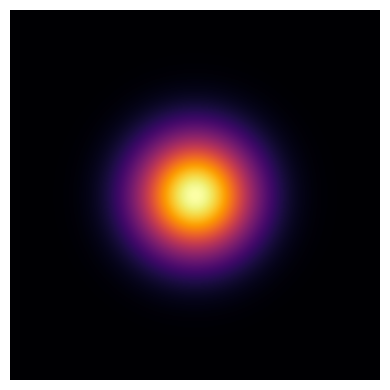

(<Figure size 400x400 with 1 Axes>, [<Axes: >])

In [6]:
# Initial output (before optimization)
uf = system(u0)
visualize_intensity(uf)

## Setup Optimizer with Selective Training

We use `optax.partition` to train only phase masks while freezing propagators:

In [7]:
no_optim = optax.set_to_zero()

def label_fn(s):
    if isinstance(s, OpticalSequence):  
        # Recursively apply label_fn on each layer while preserving structure
        return OpticalSequence(*map(label_fn, s.optical_components))
    elif isinstance(s, Phase):
        if s.is_trainable:
            return eqx.tree_at(lambda layer: layer.phase_mask, s, "phase_mask")
        else:
            return eqx.tree_at(lambda layer: layer.phase_mask, s, "frozen")
    elif isinstance(s, ASProp) or isinstance(s, RSProp):
        if s.is_trainable:
            return eqx.tree_at(lambda layer: (layer.kernel, layer.z), s, ("frozen", "prop_z"))
        else:
            return eqx.tree_at(lambda layer: (layer.kernel, layer.z), s, ("frozen", "frozen"))
    else:
        return jax.tree_at(lambda _: "frozen", s)

In [8]:
# Initialize optimizer
optim = optax.nadam(0.1)
tx = optax.transforms.partition({"phase_mask":optim, "frozen":no_optim}, label_fn)
opt_state = tx.init(system)

## Training Loop

In [9]:
@jax.jit
def train_step(s, opt_state, u, v):
    loss, grads = grad_fn(s, u, v)
    updates, opt_state = tx.update(grads, opt_state)
    system = eqx.apply_updates(s, updates)
    return system, opt_state, loss

In [10]:
# Run optimization
system = OpticalSequence(p0, phi1, p12, phi2, p0)  # Resets the system
losses = []

n_iter = 200
for i in tqdm.trange(n_iter, desc="Optimizing"):
    system, opt_state, loss = train_step(system, opt_state, u0, vf)
    losses.append(float(loss))

Optimizing: 100%|███████████████████████████████████████████████████████| 200/200 [00:00<00:00, 238.91it/s]


## Results

### Loss Curve

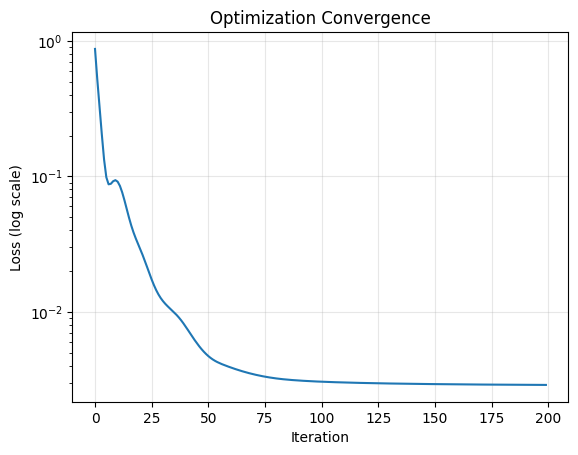

In [11]:
plt.figure()
plt.semilogy(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Optimization Convergence')
plt.grid(True, alpha=0.3)
plt.show()

### Output vs Target

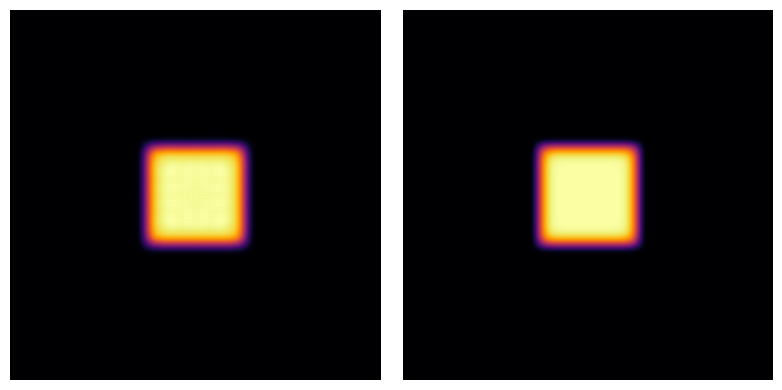

(<Figure size 800x400 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

In [12]:
uf = system(u0)
visualize_intensity(uf, vf)

### Optimized Phase Masks

In [13]:
def extract_phase_masks(system):
    masks = [comp.phase() for comp in system.optical_components if isinstance(comp, Phase)]
    return jnp.stack(masks, axis=0) if masks else None

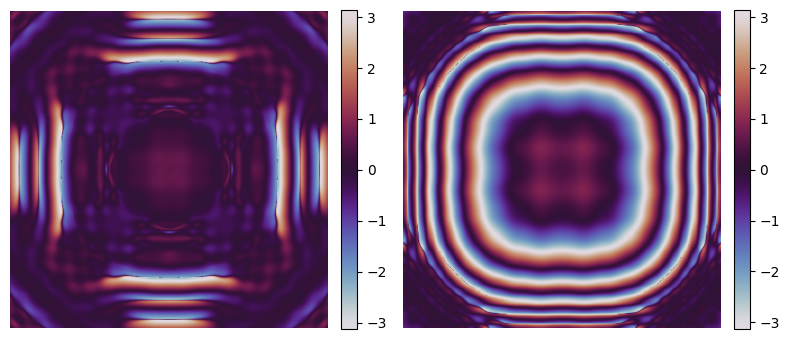

(<Figure size 800x400 with 4 Axes>, array([<Axes: >, <Axes: >], dtype=object))

In [14]:
# Visualize phases (wrapped to [-π, π])
visualize_fields(*jnp.angle(jnp.exp(1j*extract_phase_masks(system))), transform=jnp.real, cmap='twilight', colorbar=True)